# Generación de Imágenes con DCGAN: CIFAR-10

Este proyecto implementa una Deep Convolutional Generative Adversarial Network (DCGAN) para generar imágenes sintéticas de objetos naturales utilizando el dataset CIFAR-10.

### Importamos TensorFlow y otras librerías

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.18.0'

In [3]:
# Generación de GIFs
!pip install -q imageio

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargamos y preparamos el dataset

se utilizar el dataset CIFAR para entrenar el generador y el discriminador.

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [6]:
tfds.list_builders()
builder = tfds.builder("cifar10")
builder.download_and_prepare()

2025-05-23 00:29:31.598137: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [7]:
print(builder.info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/odremanferrer/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        

In [8]:
(train_dataset_raw) = builder.as_dataset(split="train", as_supervised=True)

In [9]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  # scale from [0,255] to [-1,1]
  image = (image - 127.5) / 127.5
  image = tf.image.resize(image, (32, 32))
  return image, label

In [10]:
train_dataset = train_dataset_raw.map(format_example)

2025-05-23 00:29:32.707170: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


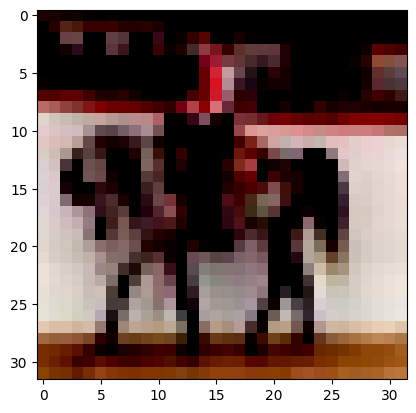

In [11]:
for image, label in train_dataset.take(1):
  plt.imshow(image, interpolation='nearest')

2025-05-23 00:29:33.173225: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


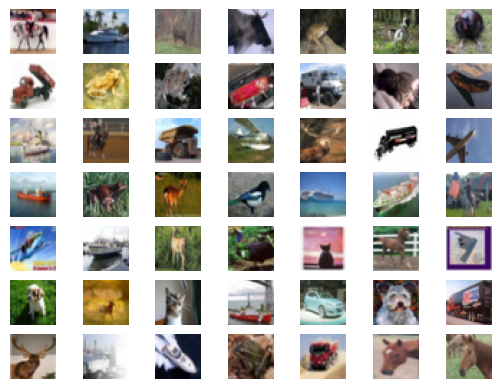

In [12]:
i = 0
for image, label in train_dataset.take(49):
  # define subplot
  plt.subplot(7, 7, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = (image + 1) / 2.0
  plt.imshow(image)
  i = i + 1
plt.show()

## Creación de modelos

Tanto el generador como el discriminador van a ser definidos usando la [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### El generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (upsampling) para producir una imágen a partir de una semilla (ruido aleatorio). Comienza con una capa `Dense`que toma la semilla como entrada, después la escala (upsample) varias veces hasta alcanzar el tamaño de imágen deseado de 32x32x3. Utilizaremos capas de activación `tf.keras.layers.LeakyReLU`, excepto para la capa de salida, que usará tanh.

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Capa de entrada: toma la semilla (ruido aleatorio) de 100 dimensiones
    # y la transforma en 8*8*512 = 32768 neuronas
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Remodelar a un tensor 4D para las capas convolucionales transpuestas
    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Nota: None es el tamaño del batch

    # Primera capa Conv2DTranspose: de 8x8x512 a 16x16x256
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Segunda capa Conv2DTranspose: de 16x16x256 a 32x32x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Tercera capa Conv2DTranspose (capa de salida): de 32x32x128 a 32x32x3 (canales RGB)
    # Usa 'tanh' como función de activación para que los píxeles estén en el rango [-1, 1]
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [15]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32768)          │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 3)      │         9,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,515,008 (28.67 MB)

 Trainable params: 7,448,704 (28.41 MB)

 Non-trainable params: 66,304 (259.00 KB)

Utiliza el generador (aún sin entrenar) para crear una imágen.

In [16]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

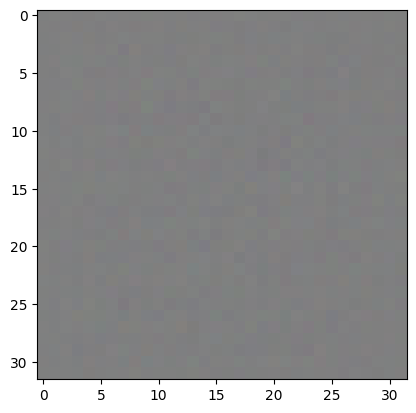

In [17]:
plt.imshow((generated_image[0, :, :, :] + 1) / 2)

### El discriminador

El discriminador es un clasificador de imágenes basado en CNNs.

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Capa de entrada: toma una imagen de 32x32x3
    # Primera capa Conv2D: de 32x32x3 a 16x16x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Dropout para regularización

    # Segunda capa Conv2D: de 16x16x64 a 8x8x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Tercera capa Conv2D: de 8x8x128 a 4x4x256 (opcional, depende de la profundidad deseada)
    # Si la quitamos, la capa Flatten tomará de 8x8x128
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Aplanar el tensor para la capa Dense
    model.add(layers.Flatten())
    # Capa Dense de salida: una sola neurona para la predicción (real o fake)
    # No se usa activación aquí porque los logits son más estables con BinaryCrossentropy(from_logits=True)
    model.add(layers.Dense(1))
    return model

Utiliza el discriminador (aún sin entrenar) para clasificar las imágenes como reales o fake. El modelo se entrenará para sacar valores positivos con imágenes reales y valores negativos con imágenes fake.

In [19]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

/opt/anaconda3/envs/yolo/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,345 (3.94 MB)

 Trainable params: 1,033,345 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

tf.Tensor([[-0.00121074]], shape=(1, 1), dtype=float32)


## Definición de la función de coste y el optimizador

Definimos la función de coste y los optimizadores para ambos modelos.

In [20]:
# Este método devuelve una función helper para calcular cross entropy loss. 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Función de coste del Discriminador

Este método cuantifica cuán bien el dicriminador es capaz de distinguir entre imágenes reales y falsas. Va a comparar las predicciones de imágenes reales con un array de 1s, y las predicciones de imágenes falsas con un array de 0s.

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Coste del generador

La función de coste del generador cuantifica cuán bien es capaz de engañar al discriminador. De forma intuitiva, si el generador funciona bien, el descriminador se equivocará. Aquí se comparar las decisiones del discriminador en las imágenes falsas con un array de 1s.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

El discriminador y el generador tendrán optimizadores separados ya que se entrenar las redes de forma separada.

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Guardar checkpoints

Este notebook también demuestra cómo guardar y recuperar modelos, lo que puede ser muy útil en caso de que el entrenamiento se pause o queramos utilizarlo a posteriori.

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definiendo el bucle de entrenamiento

In [25]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 49

# Vamos a reutilizar esta semilla para visualizar mejor el progreso en el GIF.
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle de entrenamiento comienza con el generador recibiendo una semilla aleatoria como entrada. Esta semilla se usa para producir una imagen. El discriminador se utiliza después para clasificar imágenes reales (del dataset) e imágenes falsas (producidas por el generador). El coste se calcula para cada una de las redes por separado y se actualizan los pesos mediante descenso por gradiente.

In [26]:
# Aquí utilizamos `tf.function`
# Esto hace que la función se "compile".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      train_step(image_batch)

    # Producimos imágenes para el GIF sobre la marcha
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Guardamos el modelo cada 20 épocas
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generación tras cada época
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

**Generación y guardado de imágenes**

In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Nótese que `training` está marcado como falso.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7,7))

  print(predictions.shape[0])
  for i in range(predictions.shape[0]):
      plt.subplot(7, 7, 1 + i)
      image = (predictions[i, :, :, :] + 1)/ 2.0
      plt.imshow(image)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
#!rm -rf training_checkpoints

## Entrenamos el modelo

Llamamos a la función `train()` definida anteriormente para enrtenar el generador y el discriminador de forma simultanea. Entrenar GANs es complejo, es importante que el generador y el discriminador no aventajen mucho al adversario (ambos deberían entrenar a un ritmo parecido).

Al principio del entrenamiento, las imágenes generadas van a parecer ruido aleatorio. A medida que el entrenamiento progrese, los dígitos generados irán pareciendo cada vez más reales.

49


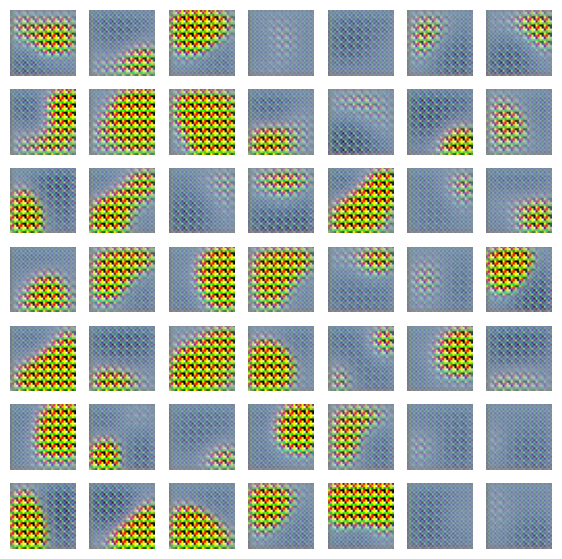

Time for epoch 1 is 591.1459209918976 sec


KeyboardInterrupt: 

In [29]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset_shuffled = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset_shuffled, EPOCHS)

Reestablecemos el último checkpoint.

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Creamos el GIF

In [0]:
# Muestra de una imágen según el número de época
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(EPOCHS)

Usamos `imageio` para crear un gif animado con estas imágenes.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

Si estás trabajando en Colab, puedes descargar la animación con el siguiente código.

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import imageio # Para crear GIFs
from IPython import display

print(f"TensorFlow Version: {tf.__version__}")

# --- 1. Cargar y Preprocesar el Dataset Fashion MNIST ---
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Nombres de las clases para visualización
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
IMG_ROWS, IMG_COLS, CHANNELS = 28, 28, 1
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)

NUM_CLASSES = 10
LATENT_DIM = 100 # Dimensión del vector de ruido
EMBEDDING_DIM = 50 # Dimensión para el embedding de la etiqueta

# Preprocesamiento
train_images = train_images.reshape(train_images.shape[0], IMG_ROWS, IMG_COLS, CHANNELS).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizar imágenes a [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Crear lotes de datos (imágenes y etiquetas)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# --- 2. Creación de Modelos Condicionales ---

# --- Generador Condicional ---
def make_conditional_generator_model():
    # Entrada de ruido
    noise_input = layers.Input(shape=(LATENT_DIM,), name="noise_input")

    # Entrada de etiqueta y embedding
    label_input = layers.Input(shape=(1,), name="label_input")
    # Embedding: convierte el índice de la etiqueta en un vector denso
    label_embedding = layers.Embedding(NUM_CLASSES, EMBEDDING_DIM, name="label_embedding")(label_input)
    # Aplanar el embedding para poder concatenarlo
    label_embedding_flat = layers.Flatten(name="label_flatten")(label_embedding)

    # Concatenar ruido y etiqueta embebida
    merged_input = layers.Concatenate(name="concatenate_noise_label")([noise_input, label_embedding_flat])

    # Capa densa para expandir y preparar para la convolución transpuesta
    x = layers.Dense(7 * 7 * 256, use_bias=False, name="dense_expand")(merged_input)
    x = layers.BatchNormalization(name="bn_g0")(x)
    x = layers.LeakyReLU(name="leaky_relu_g0")(x)

    x = layers.Reshape((7, 7, 256), name="reshape_to_conv")(x)

    # Capa Conv2DTranspose 1 (Upsample a 14x14)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, name="conv_transpose_g1")(x)
    x = layers.BatchNormalization(name="bn_g1")(x)
    x = layers.LeakyReLU(name="leaky_relu_g1")(x)

    # Capa Conv2DTranspose 2 (Upsample a 28x28)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, name="conv_transpose_g2")(x)
    x = layers.BatchNormalization(name="bn_g2")(x)
    x = layers.LeakyReLU(name="leaky_relu_g2")(x)

    # Capa de salida (1 canal para escala de grises)
    img_output = layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh', name="output_image")(x)

    model = tf.keras.Model([noise_input, label_input], img_output, name="conditional_generator")
    return model

# --- Discriminador Condicional ---
def make_conditional_discriminator_model():
    # Entrada de imagen
    img_input = layers.Input(shape=IMG_SHAPE, name="image_input") # (28, 28, 1)

    # Entrada de etiqueta y embedding
    label_input = layers.Input(shape=(1,), name="label_input")
    # Embedding de la etiqueta
    label_embedding = layers.Embedding(NUM_CLASSES, EMBEDDING_DIM, name="label_embedding")(label_input)
    # Expandir el embedding para que tenga las mismas dimensiones espaciales que la imagen
    # y pueda ser concatenado como un canal adicional.
    label_dense = layers.Dense(IMG_ROWS * IMG_COLS * 1, name="label_dense_expand")(label_embedding) # 28*28*1 = 784
    label_reshaped = layers.Reshape((IMG_ROWS, IMG_COLS, 1), name="label_reshape")(label_dense) # (28, 28, 1)

    # Concatenar imagen y etiqueta embebida (ahora la entrada tiene 2 canales)
    merged_input = layers.Concatenate(name="concatenate_image_label")([img_input, label_reshaped]) # (28, 28, 2)

    # Capa Conv2D 1 (Downsample a 14x14)
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', name="conv_d1")(merged_input)
    x = layers.LeakyReLU(name="leaky_relu_d1")(x)
    x = layers.Dropout(0.3, name="dropout_d1")(x)

    # Capa Conv2D 2 (Downsample a 7x7)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name="conv_d2")(x)
    x = layers.LeakyReLU(name="leaky_relu_d2")(x)
    x = layers.Dropout(0.3, name="dropout_d2")(x)

    x = layers.Flatten(name="flatten_features")(x)
    # Capa de salida (predicción - logits)
    output = layers.Dense(1, name="output_logit")(x) # No sigmoide aquí

    model = tf.keras.Model([img_input, label_input], output, name="conditional_discriminator")
    return model

generator = make_conditional_generator_model()
discriminator = make_conditional_discriminator_model()

print("--- GENERATOR SUMMARY ---")
generator.summary()
print("\n--- DISCRIMINATOR SUMMARY ---")
discriminator.summary()

# --- 3. Funciones de Pérdida y Optimizadores ---
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Importante: from_logits=True

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # Valores comunes para GANs
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- 4. Checkpoints ---
checkpoint_dir = './training_checkpoints_fashion_cgan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# --- 5. Bucle de Entrenamiento ---
EPOCHS = 100
NUM_EXAMPLES_TO_GENERATE = 100 # 10 ejemplos por cada una de las 10 clases

# Semilla de ruido fija para el generador (para GIFs)
fixed_seed_noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])
# Etiquetas fijas para la semilla (0,0,...,0 (10 veces), 1,1,...,1 (10 veces), ..., 9,9,...,9 (10 veces))
fixed_seed_labels_np = np.array([i for i in range(NUM_CLASSES) for _ in range(NUM_EXAMPLES_TO_GENERATE // NUM_CLASSES)], dtype=np.int32)
fixed_seed_labels_tf = tf.constant(fixed_seed_labels_np.reshape(-1,1))


@tf.function
def train_step(images, labels):
    noise = tf.random.normal([images.shape[0], LATENT_DIM])
    input_labels = tf.reshape(labels, [images.shape[0], 1]) # Asegurar forma (BATCH_SIZE, 1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, input_labels], training=True)

      real_output = discriminator([images, input_labels], training=True)
      fake_output = discriminator([generated_images, input_labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input_noise, test_input_labels_tf):
  # `training` es False para que todas las capas (ej. BatchNormalización) se ejecuten en modo inferencia.
  predictions = model([test_input_noise, test_input_labels_tf], training=False)
  fig = plt.figure(figsize=(10,10)) # Ajustado para 10x10

  num_rows_plot = NUM_EXAMPLES_TO_GENERATE // NUM_CLASSES
  num_cols_plot = NUM_CLASSES

  for i in range(predictions.shape[0]):
      plt.subplot(num_rows_plot, num_cols_plot, i+1)
      plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray') # Desnormalizar y mostrar
      # Extraer la etiqueta para el título. test_input_labels_tf es (100,1)
      label_index = test_input_labels_tf.numpy()[i,0]
      plt.title(f"{class_names[label_index]}")
      plt.axis('off')

  plt.tight_layout() # Ajusta el layout para evitar superposiciones
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def train(dataset, epochs):
  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
  # Limpiar imágenes previas si se re-entrena
  # import glob
  # for f in glob.glob(f"{checkpoint_dir}/image_at_epoch_*.png"): # Guardar en el dir de checkpoints
  #     os.remove(f)
  # for f in glob.glob("image_at_epoch_*.png"): # Limpiar también del dir actual
  # os.remove(f)


  for epoch in range(epochs):
    start_time = time.time()
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0

    for image_batch, label_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch, label_batch)
      total_gen_loss += gen_loss
      total_disc_loss += disc_loss
      num_batches +=1

    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             fixed_seed_noise,
                             fixed_seed_labels_tf)

    if (epoch + 1) % 10 == 0: # Guardar cada 10 épocas
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Epoch {epoch + 1}/{epochs}, Time: {time.time()-start_time:.2f} sec, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')

  # Generación final
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           fixed_seed_noise,
                           fixed_seed_labels_tf)

# --- 6. Entrenar ---

EPOCHS = 100 # Ajusta según sea necesario
train(train_dataset, EPOCHS)

# --- 7. Restaurar el último checkpoint (opcional) ---
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# if latest_checkpoint:
#     print(f"Restaurando desde {latest_checkpoint}")
#     checkpoint.restore(latest_checkpoint)
# else:
#     print("No se encontró checkpoint, entrenando desde cero.")


# --- 8. Crear GIF ---
anim_file = 'cgan_fashion_mnist_100_epochs.gif'
with imageio.get_writer(anim_file, mode='I', duration=0.2, loop=0) as writer: # duration más corta, loop=0 para infinito
  filenames = sorted(glob.glob('image_at_epoch_*.png')) # Asume que se guardan en el dir actual
  if not filenames:
        print("No se encontraron imágenes para crear el GIF. Asegúrate de que se guardaron en el directorio correcto.")
  else:
    print(f"Creando GIF con {len(filenames)} imágenes...")
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Añadir la última imagen varias veces para que se vea más tiempo
    if filenames:
        image = imageio.imread(filenames[-1])
        for _ in range(10): # Repite la última imagen 10 veces
            writer.append_data(image)
    print(f"GIF guardado como {anim_file}")

# Mostrar el GIF si se está en un entorno que lo permita (como IPython/Jupyter)
if IPython.version_info > (6,2,0,'') and os.path.exists(anim_file):
  display.Image(filename=anim_file)